In [33]:
!pip install elasticsearch pandasticsearch

     |████████████████████████████████| 251 kB 883 kB/s eta 0:00:01
  Created wheel for pandasticsearch: filename=pandasticsearch-0.5.3-py3-none-any.whl size=14730 sha256=157f95a402b81945d0d602be46a76d0574ddf506eb9dfb461a903a56e18e015a
  Stored in directory: /home/jovyan/.cache/pip/wheels/01/67/67/8e010cc7ad6698de5d4d1befa085a95debbe5ac8e3ea6606a3
Successfully built pandasticsearch


In [1]:
import pandas as pd
import numpy as np
import pandasticsearch as pds
from elasticsearch import Elasticsearch

In [4]:
es = Elasticsearch(['http://es01:9200'])

In [5]:
res = es.search(index='log-generator-logrus*',body={}, size=3)

In [6]:
hits = res['hits']['hits']
for hit in hits:
    source = hit['_source']
    display(source)

{'host': 'es01',
 '@timestamp': '2020-05-27T13:40:40.278508252Z',
 'message': 'Рейс 0 задерживается на 3.808s',
 'data': {'counter': 354, 'flight_number': 0, 'status': 'INFO', 'wait': 3808},
 'level': 'INFO'}

{'host': 'es01',
 '@timestamp': '2020-05-27T13:40:44.089280837Z',
 'message': 'Рейс 0 задерживается на 3.449s',
 'data': {'counter': 355, 'flight_number': 0, 'status': 'INFO', 'wait': 3449},
 'level': 'INFO'}

{'host': 'es01',
 '@timestamp': '2020-05-27T13:40:47.540687022Z',
 'message': 'Рейс 9 задерживается на 4.973s',
 'data': {'counter': 356,
  'flight_number': 9,
  'status': 'DELAYED',
  'wait': 4973},
 'level': 'ERROR'}

In [7]:
sources = [hit['_source'] for hit in hits]
datas = [field['data'] for field in sources]

df0 = pd.DataFrame.from_records(sources)
display(df0)
df1 = pd.DataFrame.from_records(datas)
display(df1)

host                      @timestamp                         message  \
0  es01  2020-05-27T13:40:40.278508252Z  Рейс 0 задерживается на 3.808s   
1  es01  2020-05-27T13:40:44.089280837Z  Рейс 0 задерживается на 3.449s   
2  es01  2020-05-27T13:40:47.540687022Z  Рейс 9 задерживается на 4.973s   

                                                data  level  
0  {'counter': 354, 'flight_number': 0, 'status':...   INFO  
1  {'counter': 355, 'flight_number': 0, 'status':...   INFO  
2  {'counter': 356, 'flight_number': 9, 'status':...  ERROR

counter  flight_number   status  wait
0      354              0     INFO  3808
1      355              0     INFO  3449
2      356              9  DELAYED  4973

In [8]:
df_norm = pd.json_normalize(hits)
df_norm

_index _type                   _id  _score  \
0  log-generator-logrus-2020-05-27  _doc  _hVdVnIBZ1VibpZBFOfa     1.0   
1  log-generator-logrus-2020-05-27  _doc  ABVdVnIBZ1VibpZBI-i8     1.0   
2  log-generator-logrus-2020-05-27  _doc  AhVdVnIBZ1VibpZBMeg4     1.0   

  _source.host              _source.@timestamp  \
0         es01  2020-05-27T13:40:40.278508252Z   
1         es01  2020-05-27T13:40:44.089280837Z   
2         es01  2020-05-27T13:40:47.540687022Z   

                  _source.message  _source.data.counter  \
0  Рейс 0 задерживается на 3.808s                   354   
1  Рейс 0 задерживается на 3.449s                   355   
2  Рейс 9 задерживается на 4.973s                   356   

   _source.data.flight_number _source.data.status  _source.data.wait  \
0                           0                INFO               3808   
1                           0                INFO               3449   
2                           9             DELAYED               4973   

  _source.level  
0          INFO  
1          INFO  
2         ERROR

# SQL запросы
Используя официальный драйвер

In [9]:
def sqlresult_to_dataframe(sql_res):
    rows = sql_res['rows']
    cols = sql_res['columns']
    col_names = [c['name'] for c in cols]
    return pd.DataFrame.from_records(rows,columns=col_names)
    
sql_query = {'query':'SELECT * FROM "log-generator-logrus*" LIMIT 3'}
sql_res = es.sql.query(sql_query)
sqlresult_to_dataframe(sql_res)


@timestamp  data.counter  data.flight_number data.status  \
0  2020-05-27T13:40:40.278Z           354                   0        INFO   
1  2020-05-28T22:05:02.259Z         12701                   2        INFO   
2  2020-05-29T00:01:04.162Z         15499                   9        INFO   

   data.wait  host level                         message  
0       3808  es01  INFO  Рейс 0 задерживается на 3.808s  
1       3674  es01  INFO  Рейс 2 задерживается на 3.674s  
2       3801  es01  INFO  Рейс 9 задерживается на 3.801s

# Pandasticsearch

In [10]:
# from pandasticsearch import Select
pds.Select.from_dict(res).to_pandas()


_index _type                   _id  _score  host  \
0  log-generator-logrus-2020-05-27  _doc  _hVdVnIBZ1VibpZBFOfa     1.0  es01   
1  log-generator-logrus-2020-05-27  _doc  ABVdVnIBZ1VibpZBI-i8     1.0  es01   
2  log-generator-logrus-2020-05-27  _doc  AhVdVnIBZ1VibpZBMeg4     1.0  es01   

                       @timestamp                         message  \
0  2020-05-27T13:40:40.278508252Z  Рейс 0 задерживается на 3.808s   
1  2020-05-27T13:40:44.089280837Z  Рейс 0 задерживается на 3.449s   
2  2020-05-27T13:40:47.540687022Z  Рейс 9 задерживается на 4.973s   

   data.counter  data.flight_number data.status  data.wait  level  
0           354                   0        INFO       3808   INFO  
1           355                   0        INFO       3449   INFO  
2           356                   9     DELAYED       4973  ERROR

interval  count
0   2020-05-29T16:21:30.000Z      9
1   2020-05-29T16:21:00.000Z     10
2   2020-05-29T16:20:30.000Z     12
3   2020-05-29T16:20:00.000Z      9
4   2020-05-29T16:19:30.000Z     13
5   2020-05-29T16:19:00.000Z     14
6   2020-05-29T16:18:30.000Z     10
7   2020-05-29T16:18:00.000Z     14
8   2020-05-29T16:17:30.000Z     12
9   2020-05-29T16:17:00.000Z     11
10  2020-05-29T16:16:30.000Z     11
11  2020-05-29T16:16:00.000Z     12
12  2020-05-29T16:15:30.000Z     12
13  2020-05-29T16:15:00.000Z      9
14  2020-05-29T16:14:30.000Z     12
15  2020-05-29T16:14:00.000Z     14
16  2020-05-29T16:13:30.000Z     14
17  2020-05-29T16:13:00.000Z     14
18  2020-05-29T16:12:30.000Z     12
19  2020-05-29T16:12:00.000Z     12

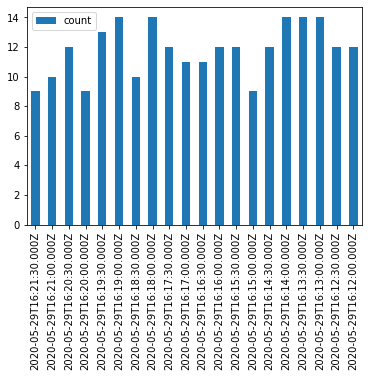

In [35]:
q = '''
  SELECT HISTOGRAM("@timestamp", INTERVAL 30 SECOND) as interval, 
  count(*) as count
  FROM "log-generator-logrus*"
  GROUP by interval
  ORDER BY interval DESC
  LIMIT 20
'''
client = pds.RestClient('http://es01:9200', '_sql')
r = client.post({'query':q})
df = sqlresult_to_dataframe(r)
display(df)
# ax = df.plot.bar()


# https://stackoverflow.com/questions/49961169/show-categorical-x-axis-values-when-making-line-plot-from-pandas-series-in-matpl

ax = df.plot.bar()
ax.set_xticks(df.index)
ax.set_xticklabels(df.interval, rotation=90)
display(ax)